<a href="https://colab.research.google.com/github/ivyclare/Project-50_Projects_In_Deep_Learning/blob/master/Deep_Cars_Identifying_Car_Brands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torchvision import datasets,transforms,models
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import *

import time
import json
import copy
import os
import glob

from PIL import Image

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.backends.cudnn.enabled = False
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
# torch.backends.cudnn.enabled

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Downloading the data from Kaggle

!pip install kaggle
!pip install -q kaggle

!mkdir .kaggle

import json
token = {"username":"ivyclare","key":"17ee8bd3b41486d62e7eb9257bd812d4"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

!chmod 600 /content/.kaggle/kaggle.json

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
 
!kaggle config set -n path -v{/content}

#!kaggle datasets download -d spaics/hackathon-blossom-flower-classification -p /content
#!kaggle competitions download -c dog-breed-identification -p /content
!kaggle competitions download -c virtual-hack -p /content
#!kaggle competitions download -c dog-breed-identification -p /content
!unzip \*.zip

# #!unzip \*.zip

In [0]:
# Tansform with data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),                                  
        transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}


In [0]:
label_df = pd.read_csv('names.csv', names=["label"])
label_df.head()

,label
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [0]:
#Loading in the dataset

train_dir = 'car_data/train'
test_dir = 'car_data/test'
label_dir = 'names.csv'

batch_size=32
dataset = datasets.ImageFolder(train_dir,transform=data_transforms['train'])

# splitting our data
valid_size  = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'valid': valid_size}

# now we get our datasets
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Loading datasets into dataloader 
dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
              'valid': DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)}

print("Total Number of Samples: ",len(dataset))
print("Number of Samples in Train: ",len(train_dataset))
print("Number of Samples in Valid: ",len(valid_dataset))
print("Number of Classes: ",len(dataset.classes))

print(dataset.classes[0])

8144
Total Number of Samples:  8144
Number of Samples in Train:  7330
Number of Samples in Valid:  814
Number of Classes:  196
AM General Hummer SUV 2000


### Data Exploration and Visualization

In [0]:
# ## Finding the number of samples per class (From https://www.kaggle.com/venkatarathnam/dog-breed-identification)
# label_count_lis = [0]*len(dataset.classes)
# label_count_lis = [0]*len(dataset.classes)
# for classname, row in dataset.classes:
#     label = dataset.classes.index.index(row['label'])
#     label_count_lis[label] += 1
# print ("Minimum samples per class : {0}".format(min(label_count_lis)))
# print ("Maximum samples per class : {0}".format(max(label_count_lis)))

# plt.figure()
# f, ax = plt.subplots(figsize=(15,5))
# plt.bar(np.arange(len(dataset.classes)), label_count_lis)
# plt.xticks(np.arange(len(dataset.classes)), np.arange(len(dataset.classes)))
# plt.ylabel("# of samples")
# plt.xlabel("Classes")
# plt.title('Train Set')
# plt.show()


 Sizes of Datasets:  814 7330
 Image Size torch.Size([32, 3, 224, 224])
tensor(38)


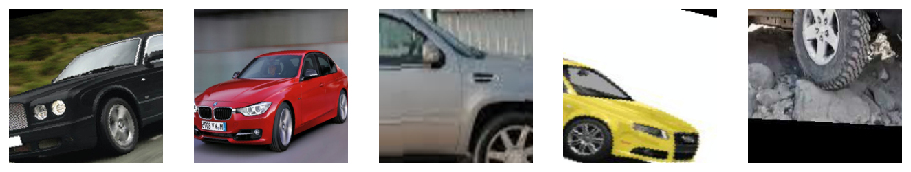

In [0]:
## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


print(" Sizes of Datasets: ", len(valid_dataset), len(train_dataset))
# Displaying Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    #ax.set_title(label_map[class_names[labels[ii].item()]])
    imshow(images[ii], ax=ax, normalize=True)

       

### Building and Training The Model

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'inception' #vgg
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
elif model_name == 'resnet':
    model = models.resnet152(pretrained=True) 
    #model = models.resnet34(pretrained=True)
    num_in_features = 2048 #512 
    print(model.fc)
elif model_name == 'inception':
  model = models.inception_v3(pretrained=True)
  model.aux_logits=False
  num_in_features = 2048
  print(model.fc)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 111005169.64it/s]


Linear(in_features=2048, out_features=1000, bias=True)


In [0]:
#Freezing model parameters and defining the fully connected network to be attached to the model, loss function and the optimizer.
#We there after put the model on the GPUs
for param in model.parameters():
  param.require_grad = False
  
# Create Custom Classifier
def build_classifier(num_in_features, hidden_layers, num_out_features):
   
    classifier = nn.Sequential()
    if hidden_layers == None:
      
        classifier.add_module('fc0', nn.Linear(num_in_features, 196))
        
    else:
      
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        
#         classifier.add_module('relu1', nn.ReLU())
#         classifier.add_module('drop1', nn.Dropout(.5))
        
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [0]:
hidden_layers = None #[1050 , 500] #[4096, 1024] #None#[4096, 1024, 256][512, 256, 128] [1050 , 500]

classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)

 # Defining model hyperparameters
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer_conv = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.001, momentum=0.9)
   # Decay LR by a factor of 0.1 every 4 epochs
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    #criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.0001,weight_decay=0.001, momentum=0.9)
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'resnet':
  model.fc = classifier
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
  #sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

#     #criterion = nn.NLLLoss()
#     optimizer = optim.Adam(model.fc.parameters(), lr= 0.00001)
#     sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
#criterion = nn.CrossEntropyLoss()

elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
    #sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
else:
    pass

Sequential(
  (fc0): Linear(in_features=2048, out_features=196, bias=True)
)


#### Training the Model


In [0]:
def train_model(model, criterion, optimizer, sched, num_epochs=5,device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':            
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # calculate average time over an epoch
            #elapshed_epoch = time.time() - start/            
            #print('Epoch {}/{} - completed in: {:.0f}m {:.0f}s'.format(epoch+1, num_epochs,elapshed_epoch // 60, elapshed_epoch % 60))
            
            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'valid'):
              #sched.step(epoch_acc)
              valid_results.append([epoch_loss,epoch_acc])
                                   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())       
                #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
                #model_save_name = "ResNetDeepFlowers.pt"
                model_save_name = "resnetCars2.pt"
                path = F"/content/drive/My Drive/{model_save_name}"
                torch.save(model.state_dict(), path)        

        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model,train_results,valid_results
  #Resnet34 = 68.8%, 50 epochs, vggDeepFlowers

In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/resnetCars1.pt'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
epochs = 60
model.to(device)
model,train_results,valid_results = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/60
----------
train Loss: 0.5672 Acc: 0.8441
valid Loss: 0.6750 Acc: 0.8329

Epoch 2/60
----------
train Loss: 0.6184 Acc: 0.8357
valid Loss: 0.5980 Acc: 0.8415

Epoch 3/60
----------
train Loss: 0.5695 Acc: 0.8487
valid Loss: 0.5503 Acc: 0.8575

Epoch 4/60
----------
train Loss: 0.6020 Acc: 0.8342
valid Loss: 0.6641 Acc: 0.8403

Epoch 5/60
----------
train Loss: 0.5546 Acc: 0.8498
valid Loss: 0.6638 Acc: 0.8219

Epoch 6/60
----------
train Loss: 0.5482 Acc: 0.8528
valid Loss: 0.6211 Acc: 0.8329

Epoch 7/60
----------
train Loss: 0.5467 Acc: 0.8540
valid Loss: 0.6727 Acc: 0.8292

Epoch 8/60
----------
train Loss: 0.5692 Acc: 0.8460
valid Loss: 0.6882 Acc: 0.8206

Epoch 9/60
----------
train Loss: 0.5403 Acc: 0.8539
valid Loss: 0.6068 Acc: 0.8280

Epoch 10/60
----------
train Loss: 0.5232 Acc: 0.8613
valid Loss: 0.6875 Acc: 0.8256

Epoch 11/60
----------
train Loss: 0.5515 Acc: 0.8569
valid Loss: 0.7818 Acc: 0.8010

Epoch 12/60
----------
train Loss: 0.5198 Acc: 0.8644
valid Los

KeyboardInterrupt: ignored

In [0]:
# resnet34
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# """
# probably not the best metric to track, but we are tracking the training accuracy and measuring whether
# it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
# However in this model it did not benefit me.
# """
# lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

### Load Trained Model

In [0]:
#Load trained model and continue training
model.load_state_dict(torch.load('/content/drive/My Drive/resnetCars2.pt'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### Predictions On Test Sample

In [0]:
from pathlib import Path


# Load the datasets with ImageFolder
# data_dir = 'flower_data'
# train_dir = data_dir + '/train'
# valid_dir = data_dir + '/valid'
# test_dir = data_dir +'/test set'
# test_dirs = data_dir +'/test/1'
label_df = pd.read_csv('names.csv', names=["label"])

test_dir = 'car_data/test'

with torch.no_grad():
  model.eval()
  # test_data = next(iter(dataloaders['test']))
  
  dataset = datasets.ImageFolder(test_dir,transform=data_transforms['test'])
  
  testloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                             shuffle=False, num_workers=2)
 
  image_names = []
  for index in testloader.dataset.imgs:
    #image_names.append(index[0].split('/')[-1])
    image_names.append(Path(index[0]).stem)

  results = []
  #results.append(image_names)
  
  for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    for i in predicted:
        results.append(int(i)+1)
        

In [0]:
print("Predictions on Test Set:")
df = pd.DataFrame({'Id': image_names, 'Predicted': results})
pd.set_option('display.max_colwidth', -1)

# df = df.sort_values(by=['Id']) 
df.to_csv('/content/drive/My Drive/predictions.csv')
df

Predictions on Test Set:


,Id,Predicted
0,00076,1
1,00457,1
2,00684,1
3,01117,1
4,01167,125
5,01199,1
6,01226,1
7,01461,108
8,01518,1
9,01538,149
